In [1]:
from os.path import join, dirname, abspath

import matplotlib.pyplot as plt

from pypsa import Network

from postprocessing.utils import *

import shapely.wkt

### Parameters

In [114]:
year = 2018

techs = ["ccgt", "pv_residential_national", "pv_utility_national",
         "wind_offshore_national", "wind_onshore_national",
         "AC", "DC", "Li-ion", "nuclear"]
techs_generic = ["ccgt", "pv_residential", "pv_utility",
                 "wind_offshore", "wind_onshore",
                 "AC", "DC", "Li-ion", "nuclear"]

regions_dict = {'Iberia': ['ES', 'PT'],
                'Central West': ['NL', 'BE', 'LU', 'FR', 'DE'],
                'Nordics': ['DK', 'NO', 'SE', 'FI'],
                'British Isles': ['GB', 'IE'],
                'Central South': ['CH', 'IT', 'AT', 'SI'],
                'East': ['PL', 'HU', 'CZ', 'SK', 'LV', 'LT', 'EE'],
                'South': ['HR', 'GR', 'BG', 'RO'],
                'NA': ["DZ", "EG", "MA", "LY", "TN"],
                'ME': ["CY", "IL", "JO", "SA", "SY"],
                'GLIS': ["GL", "IS"]}

cases = ["20201119_150737"]

### Loading solved nets

In [115]:
nets = dict.fromkeys(cases)
for case in cases:
    output_dir = f'../../output/remote_siting/{case}/'
    net = Network()
    net.import_from_csv_folder(output_dir)
    nets[case] = net
    
    # Converting polygons strings to Polygon object
    for region_type in ["onshore_region", "offshore_region"]:
        regions = net.buses[region_type].values
        # Convert strings
        for i, region in enumerate(regions):
            if isinstance(region, str):
                regions[i] = shapely.wkt.loads(region)

INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units


### Compute costs

In [110]:
# Technology cost
techs = ["AC", "DC", "ccgt", "Li-ion", "pv_residential_national", "pv_utility_national",
         "pv_utility_noneu", "nuclear", "phs", "ror", "sto",
         "wind_onshore_national", "wind_onshore_noneu", "wind_offshore_national"]
tech_costs = pd.DataFrame(0., index=techs, columns=cases)
cost_type = "marginal_cost"
for case in cases:
    net = nets[case]
    for tech in techs:
        if tech in ["AC", "DC"]:
            # Line cost per 1000km and 1GW
            links = net.links[net.links.carrier == tech]
            cost = (links[cost_type]/links.length).unique()*1000
        elif tech in ["Li-ion", "phs", "sto"]:
            cost = net.storage_units[net.storage_units.type == tech][cost_type].unique()
        else:
            cost = net.generators[net.generators.type == tech][cost_type].unique()
        if len(cost) != 0:
            tech_costs.loc[tech, case] = cost[0]
        else:
            print(tech)
if cost_type == "capital_cost":
    print(f"Cost per GW:\n{tech_costs}")
else:
    print(f"Cost per TWh:\n{tech_costs*1000}")

DC
pv_residential_national
pv_utility_national
pv_utility_noneu
wind_onshore_national
wind_onshore_noneu
wind_offshore_national
Cost per TWh:
                         20201119_150016
AC                                 0.000
DC                                 0.000
ccgt                              71.441
Li-ion                             0.270
pv_residential_national            0.000
pv_utility_national                0.000
pv_utility_noneu                   0.000
nuclear                            9.044
phs                                0.270
ror                                8.100
sto                                6.000
wind_onshore_national              0.000
wind_onshore_noneu                 0.000
wind_offshore_national             0.000


In [111]:
# System cost
costs = pd.DataFrame(index=["Generation", "Transmission", "Storage"], columns=cases)
for case in cases:
    net = nets[case]
    cost = get_generators_cost(net).sum() + get_links_capex(net).sum() + get_storage_cost(net).sum()
    costs.loc["Generation", case] = get_generators_cost(net).sum()
    costs.loc["Transmission", case] = get_links_capex(net).sum()
    costs.loc["Storage", case] = get_storage_cost(net).sum()
costs.loc["Total"] = costs.sum().round(3)
print(costs)

             20201119_150016
Generation           10.1373
Transmission     1.66048e-08
Storage           0.00153528
Total                 10.139


### Capacities

#### Total capacities

In [112]:
techs = ["ccgt", "pv_residential_national", "pv_utility_national",
         "wind_offshore_national", "wind_onshore_national",
         "AC", "DC", "Li-ion", "nuclear"]
capacities_df = pd.DataFrame(columns=cases, index=techs_generic)
capacities_init_df = pd.DataFrame(columns=cases, index=techs_generic)
for case in cases:
    net = nets[case]
    capacities = pd.concat([get_generators_capacity(net)["final"],
                            get_links_capacity(net)["new [TWkm]"] + get_links_capacity(net)["init [TWkm]"],
                            get_storage_energy_capacity(net)["new [GWh]"]])
    for tech in techs_generic:
        capacities_df.loc[tech, case] = capacities[capacities.index.str.startswith(tech)].sum().round()
    # capacities_df[case] = capacities[techs].round().values
    capacities = pd.concat([get_generators_capacity(net)["init"],
                            get_links_capacity(net)["init [TWkm]"],
                            get_storage_power_capacity(net)["init [GW]"]])
    capacities_init_df[case] = capacities[techs].round().values
ax1 = capacities_df.plot(kind="bar")
capacities_init_df.plot(ax=ax1, kind="bar", color='k', alpha=0.5)
plt.xticks(rotation="45")
plt.savefig(f"capacities_{year}.png", bbox_inches="tight")

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['pv_residential_national', 'pv_utility_national',\n       'wind_offshore_national', 'wind_onshore_national', 'DC'],\n      dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

### Capacities per region

In [63]:
# Compute
storage_per_region = pd.DataFrame(0., index=regions_dict.keys(), columns=cases)
ccgt_per_region = pd.DataFrame(0., index=regions_dict.keys(), columns=cases)
pv_per_region_init = pd.DataFrame(0., index=regions_dict.keys(), columns=cases)
pv_per_region_final = pd.DataFrame(0., index=regions_dict.keys(), columns=cases)
pvr_per_region_init = pd.DataFrame(0., index=regions_dict.keys(), columns=cases)
pvr_per_region_final = pd.DataFrame(0., index=regions_dict.keys(), columns=cases)
won_per_region_init = pd.DataFrame(0., index=regions_dict.keys(), columns=cases)
won_per_region_final = pd.DataFrame(0., index=regions_dict.keys(), columns=cases)
woff_per_region_init = pd.DataFrame(0., index=regions_dict.keys(), columns=cases)
woff_per_region_final = pd.DataFrame(0., index=regions_dict.keys(), columns=cases)

init_or_max = "init"
for case in cases:
    net = nets[case]
    capacities_df = pd.DataFrame(0., columns=regions_dict.keys(), 
                                 index=["ccgt", "Li-ion", "pv_residential", 
                                        "pv_utility", "wind_onshore", "wind_offshore"])
    for region in regions_dict.keys():
        # Li-ion
        df = get_storage_power_capacity(net, regions_dict[region], ["Li-ion"])
        if 'Li-ion' in df.index:
            storage_per_region.loc[region, case] = df.loc["Li-ion", "new [GW]"]
        capacities_df.loc["Li-ion", region] = storage_per_region.loc[region, case]
        
        df = get_generators_capacity(net, regions_dict[region], ["ccgt"])
        # CCGT
        if 'ccgt' in df.index:
            ccgt_per_region.loc[region, case] = df.loc["ccgt", "new"]
        capacities_df.loc["ccgt", region] = ccgt_per_region.loc[region, case]

        # PV utility
        df = get_generators_capacity(net, regions_dict[region], ["pv_utility_national", "pv_utility_noneu"])
        if 'pv_utility_national' in df.index:
            pv_per_region_init.loc[region, case] = df.loc["pv_utility_national", init_or_max]
            pv_per_region_final.loc[region, case] = df.loc["pv_utility_national", "final"]
        if 'pv_utility_noneu' in df.index:
            pv_per_region_init.loc[region, case] = df.loc["pv_utility_noneu", init_or_max]
            pv_per_region_final.loc[region, case] = df.loc["pv_utility_noneu", "final"]
        capacities_df.loc["pv_utility", region] = pv_per_region_final.loc[region, case]

        
        # PV residential
        df = get_generators_capacity(net, regions_dict[region], ["pv_residential_national"])
        if 'pv_residential_national' in df.index:
            pvr_per_region_init.loc[region, case] = df.loc["pv_residential_national", init_or_max]
            pvr_per_region_final.loc[region, case] = df.loc["pv_residential_national", "final"]
        capacities_df.loc["pv_residential", region] = pvr_per_region_final.loc[region, case]

        # Wind onshore
        df = get_generators_capacity(net, regions_dict[region], ["wind_onshore_national", "wind_onshore_noneu"])
        if 'wind_onshore_national' in df.index:
            won_per_region_init.loc[region, case] = df.loc["wind_onshore_national", init_or_max]
            won_per_region_final.loc[region, case] = df.loc["wind_onshore_national", "final"]
        if 'wind_onshore_noneu' in df.index:
            won_per_region_init.loc[region, case] = df.loc["wind_onshore_noneu", init_or_max]
            won_per_region_final.loc[region, case] = df.loc["wind_onshore_noneu", "final"]
        capacities_df.loc["wind_onshore", region] = won_per_region_final.loc[region, case]

        # Wind offshore
        df = get_generators_capacity(net, regions_dict[region], ["wind_offshore_national", "wind_offshore_noneu"])
        if 'wind_offshore_national' in df.index:
            woff_per_region_init.loc[region, case] = df.loc["wind_offshore_national", init_or_max]
            woff_per_region_final.loc[region, case] = df.loc["wind_offshore_national", "final"]
        if 'wind_offshore_noneu' in df.index:
            woff_per_region_init.loc[region, case] = df.loc["wind_offshore_noneu", init_or_max]
            woff_per_region_final.loc[region, case] = df.loc["wind_offshore_noneu", "final"]
        capacities_df.loc["wind_offshore", region] = woff_per_region_final.loc[region, case]

        #capacities_df.round(3).to_csv(f"capacities_per_region_{case}.csv")

In [7]:
# Save
storage_per_region.round(3).to_csv("liion.csv")
ccgt_per_region.round(3).to_csv("ccgt.csv")
pv_per_region_final.round(3).to_csv("pv_utility.csv")
pvr_per_region_final.round(3).to_csv("pv_residential.csv")  
won_per_region_final.round(3).to_csv("wind_onshore.csv")  
woff_per_region_final.round(3).to_csv("wind_offshore.csv")

<Figure size 432x288 with 0 Axes>

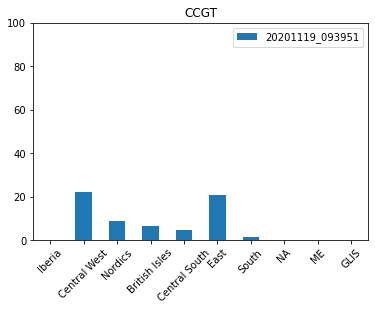

<Figure size 432x288 with 0 Axes>

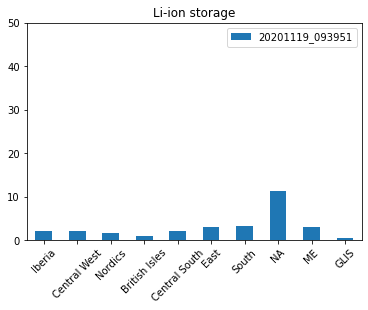

<Figure size 432x288 with 0 Axes>

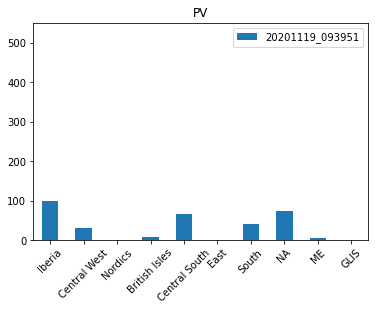

<Figure size 432x288 with 0 Axes>

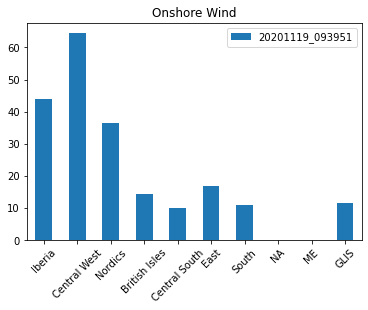

<Figure size 432x288 with 0 Axes>

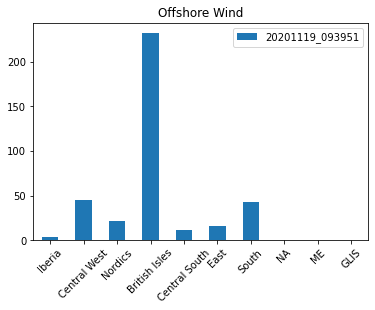

In [64]:
# Plot
plt.figure()
ccgt_per_region.plot(kind="bar")
plt.xticks(rotation="45")
plt.ylim([0, 100])
plt.title("CCGT")
plt.savefig(f"ccgt_capacities_{year}.png", bbox_inches="tight")

plt.figure()
storage_per_region.plot(kind="bar")
plt.xticks(rotation="45")
plt.ylim([0, 50])
plt.title("Li-ion storage")
plt.savefig(f"storage_capacities_{year}.png", bbox_inches="tight")

plt.figure()
ax = pv_per_region_final.plot(kind="bar")
pv_per_region_init.plot(ax=ax, kind="bar", color='k', alpha=0.5)
plt.xticks(rotation="45")
plt.legend(cases)
plt.ylim([0, 550])
plt.title("PV")
plt.savefig(f"pv_capacities_{year}.png", bbox_inches="tight")

plt.figure()
ax1 = won_per_region_final.plot(kind="bar")
won_per_region_init.plot(ax=ax1, kind="bar", color='k', alpha=0.5)
plt.xticks(rotation="45")
plt.legend(cases)
# plt.ylim([0, 225])
plt.title("Onshore Wind")
plt.savefig(f"windon_capacities_{year}.png", bbox_inches="tight")

plt.figure()
ax2 = woff_per_region_final.plot(kind="bar")
woff_per_region_init.plot(ax=ax2, kind="bar", color='k', alpha=0.5)
plt.xticks(rotation="45")
plt.legend(cases)
# plt.ylim([0, 100])
plt.title("Offshore Wind")
plt.savefig(f"windoff_capacities_{year}.png", bbox_inches="tight")

#### Geographical distribution of capacities

In [67]:
# Check number of sites per tech
nbs_df = pd.DataFrame(columns=cases, index=["Wind onshore", "Wind offshore", "PV utility", "PV residential",
                                                  "Wind onshore NonEU", "PV utility NonEU",  "RES"])
for case in cases:
    net = nets[case]
    nbs_df.loc["Wind onshore", case] = len(net.generators[net.generators.type == 'wind_onshore_national'])
    nbs_df.loc["Wind onshore NonEU", case] = len(net.generators[net.generators.type == 'wind_onshore_noneu'])
    nbs_df.loc["Wind offshore", case] = len(net.generators[net.generators.type == 'wind_offshore_national'])
    nbs_df.loc["PV utility", case] = len(net.generators[net.generators.type == 'pv_utility_national'])
    nbs_df.loc["PV utility NonEU", case] = len(net.generators[net.generators.type == 'pv_utility_noneu'])
    nbs_df.loc["PV residential", case] = len(net.generators[net.generators.type == 'pv_residential_national'])
    nbs_df.loc["RES", case] = nbs_df[case].sum()
print(nbs_df)

nbs_df_c = pd.DataFrame(columns=cases, index=["Wind onshore", "Wind offshore", "PV utility", "PV residential",
                                                    "Wind onshore NonEU", "PV utility NonEU",  "RES"])
min_cap = 1e-1
for case in cases:
    net = nets[case]
    nbs_df_c.loc["Wind onshore", case] = len(net.generators[(net.generators.type == 'wind_onshore_national') & (net.generators.p_nom_opt > min_cap)])
    nbs_df_c.loc["Wind onshore NonEU", case] = len(net.generators[(net.generators.type == 'wind_onshore_noneu') & (net.generators.p_nom_opt > min_cap)])
    nbs_df_c.loc["Wind offshore", case] = len(net.generators[(net.generators.type == 'wind_offshore_national') & (net.generators.p_nom_opt > min_cap)])
    nbs_df_c.loc["PV utility", case] = len(net.generators[(net.generators.type == 'pv_utility_national') & (net.generators.p_nom_opt > min_cap)])
    nbs_df_c.loc["PV utility NonEU", case] = len(net.generators[(net.generators.type == 'pv_utility_noneu') & (net.generators.p_nom_opt > min_cap)])
    nbs_df_c.loc["PV residential", case] = len(net.generators[(net.generators.type == 'pv_residential_national') & (net.generators.p_nom_opt > min_cap)])
    nbs_df_c.loc["RES", case] = nbs_df_c[case].sum()
print(nbs_df_c)


                   20201119_093951
Wind onshore                   176
Wind offshore                  106
PV utility                     118
PV residential                 176
Wind onshore NonEU               8
PV utility NonEU                93
RES                            677
                   20201119_093951
Wind onshore                   138
Wind offshore                   84
PV utility                      95
PV residential                 175
Wind onshore NonEU               8
PV utility NonEU                90
RES                            590


##### Map of regions

name
Gen wind_onshore_national -10.0-52.0    1.330477
Gen wind_onshore_national -10.0-54.0    0.091125
Gen wind_onshore_national -8.0-38.0     8.877870
Gen wind_onshore_national -8.0-40.0     0.352236
Gen wind_onshore_national -8.0-42.0     0.140425
                                          ...   
Gen wind_onshore_noneu -20.0-64.0       0.189237
Gen wind_onshore_noneu -20.0-66.0       1.190666
Gen wind_onshore_noneu -18.0-64.0       0.191711
Gen wind_onshore_noneu -18.0-66.0       0.114030
Gen wind_onshore_noneu -16.0-66.0       1.680805
Name: p_nom_opt, Length: 290, dtype: float64


/home/duboisa1/miniconda3/envs/replan/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning:


The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.



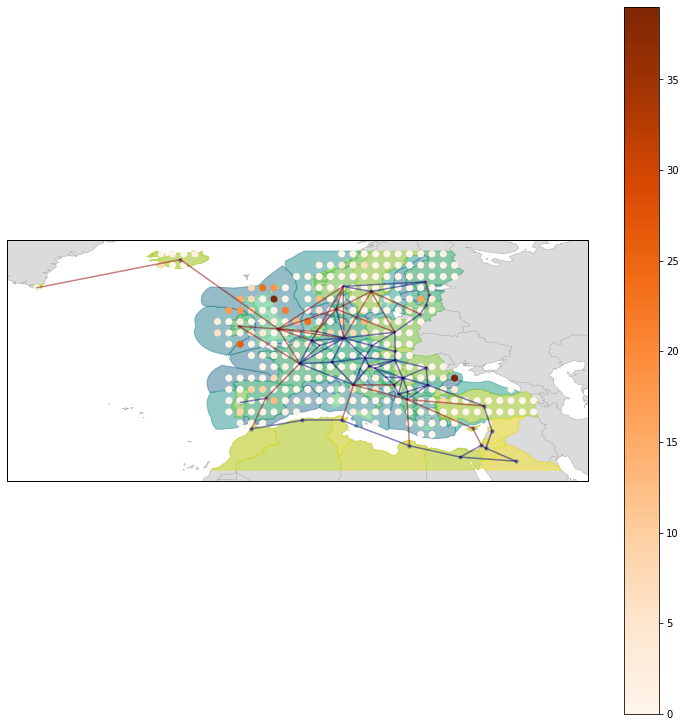

In [76]:
from iepy.topologies.core.plot import plot_topology
import shapely.wkt

min_cap = 1e-3
res_techs = ["wind_onshore_noneu", "wind_onshore_national", "wind_offshore_national"]
# Plot region shapes
ax = plot_topology(net.buses, net.links)
# Find missing generators
res_gens = net.generators[(net.generators.type.isin(res_techs)) & (net.generators.p_nom_opt > min_cap)]
print(res_gens.p_nom_opt)
#print(net.generators[net.generators.bus == "TN"])
x = res_gens["x"].values
y = res_gens["y"].values
#values = net.generators_t.p_max_pu[res_gens.index].mean()
values = res_gens.p_nom_opt
map1 = ax.scatter(x, y, c=values, cmap='Oranges', vmin=0)
plt.colorbar(map1, ax=ax)

### Transmission

In [70]:
# Capacity overall
capacities_df = pd.DataFrame(index=["AC", "DC"], columns=["init"] + cases)
for case in cases:
    net = nets[case]
    capacities = get_links_capacity(net)
    capacities_df["init"] = capacities["init [TWkm]"]
    capacities_df[case] = capacities["new [TWkm]"]
print(f"Added capacity (TWkm):\n {capacities_df}")

# In Europe
capacities_eu_df = pd.DataFrame(index=["AC", "DC"], columns=["init"] + cases)
outside_nodes = regions_dict["GLIS"] + regions_dict["NA"] + regions_dict["ME"]
for case in cases:
    net = nets[case]
    capacities = get_links_capacity(net, outside_nodes)
    capacities_eu_df["init"] = capacities["init [TWkm]"]
    capacities_eu_df[case] = capacities["new [TWkm]"]
print(f"Added capacity in Europe (TWkm):\n {capacities_eu_df}")

Added capacity (TWkm):
          init  20201119_093951
AC  49.002127        67.171217
DC  24.637330       141.958451
Added capacity in Europe (TWkm):
          init  20201119_093951
AC  49.002127        64.569798
DC  24.637330       113.765025


In [71]:
# Maps of flows
from postprocessing.plotly import SizingPlotly

for case in cases:
    net = nets[case]
    #net.iplot()
    sp = SizingPlotly(net)
    fig = sp.plot_topology()
    #fig = sp.plot_capacity("init")
    fig.show()
    # fig = sp.plot_capacity("final")
    #fig.show()
    # fig.write_image(f"transmission_capacity_{case}.png", dpi=300)
    # fig.write_html(f"{case}_topology_heatmap.html", auto_open=True)

In [116]:
# Imports in each countries
for bus in net.buses.index:
    print(bus)
    links_in = net.links[net.links.bus1 == bus].index
    links_out = net.links[net.links.bus0 == bus].index
    
    print(net.loads_t.p[net.loads[net.loads.bus == bus].index].sum())
    print(net.generators_t.p[net.generators[(net.generators.type == "load") & (net.generators.bus == bus)].index].sum())
    imports = 0.
    if not links_in.empty:
        imports += net.links_t.p0[links_in].sum().sum()
    if not links_out.empty:
        imports -= net.links_t.p0[links_out].sum().sum()
    print(imports)

BE
Load BE    437.979
dtype: float64
Load shed BE    231.301072
dtype: float64
21.06339313302637
DE
Load DE    2525.05
dtype: float64
Load shed DE    2122.487119
dtype: float64
103.11417095759002
FR
Load FR    2786.562
dtype: float64
Load shed FR    622.232024
dtype: float64
-133.497253463391
LU
Load LU    19.667
dtype: float64
Load shed LU    8.838474
dtype: float64
-48.631085788079076
NL
Load NL    619.166
dtype: float64
Load shed NL    369.227001
dtype: float64
57.95077516085371
